## Задача проекта и описание данных для анализа

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

Задача проекта - разработать модель, предсказывающую температуру расплавленного состояния сплава, которая будет способствовать бизнесу в работе над своими издержками.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Распишу этапы обработки стали и используемые таблицы:
<br><br>1. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами: используем таблицу data_arc.csv - данные об электродах.
<br><br>2. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ: используем таблицу data_temp.csv - результаты измерения температуры;
<br><br>3. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов: используем таблицы:
    <br> - data_bulk.csv - данные о подаче сыпучих материалов (объём);
    <br> - data_bulk_time.csv - данные о подаче сыпучих материалов (время);
<br><br>или проволоку через специальный трайб-аппарат (англ. tribe, «масса»): используем таблицы:
    <br>- data_wire.csv - данные о проволочных материалах (объём);
    <br>- data_wire_time.csv - данные о проволочных материалах (время).
<br><br>4. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом: используем таблицу data_gas.csv - данные о продувке сплава газом.
<br><br>5. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки: используем таблицу data_temp.csv - результаты измерения температуры.
<br><br>Целевой признак находится в таблице data_temp.csv.

Т.к. целевой признак - температура стали - количественный, решаем задачу регрессии. Буду использовать модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor.

План работы:
<br>1. Проанализировать и подготовить данные к обработке.
<br>2. Объединить таблицы по номеру партии - полю key.
<br>3. Разбить данные на тренировочную и тестовые выборки.
<br>4. Обучить несколько моделей, использовать подбор гиперпараметров с помощью GridSearchCV и RandomizedSearchCV.
<br>5. Определить наилучшую модель по значению MAE.
<br>6. Предсказать температуру на тестовой выборке.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')

In [3]:
display('Данные об электродах', data_arc)

'Данные об электродах'

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Переименую название столбцов на латиницу в таблицах, где указано на кириллице.

In [4]:
data_arc.rename(columns = {'Начало нагрева дугой': 'start_time',
                           'Конец нагрева дугой': 'end_time',
                           'Активная мощность': 'active_power',
                           'Реактивная мощность': 'reactive_power'
                          },
                inplace = True)

#data_arc

In [5]:
display('Количество дубликатов "Данные об электродах":', data_arc.duplicated().sum())
display('Количество пропущенных значений "Данные об электродах":', data_arc.isna().sum())

'Количество дубликатов "Данные об электродах":'

0

'Количество пропущенных значений "Данные об электродах":'

key               0
start_time        0
end_time          0
active_power      0
reactive_power    0
dtype: int64

Пропущенных значений нет, вся таблица заполнена данными.

In [6]:
#просмотр статистических данных

data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
data_arc[data_arc['reactive_power'] == data_arc['reactive_power'].min()]

,key,start_time,end_time,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Удалю отрицательное значение reactive_power.

In [8]:
#список партий, в которых нет или недостаточно данных для анализа

nan_key = []

nan_key.extend( data_arc[data_arc['reactive_power'] == data_arc['reactive_power'].min()]['key'] )

In [9]:
data_arc = data_arc.drop(data_arc[data_arc['reactive_power'] == data_arc['reactive_power'].min()].index)

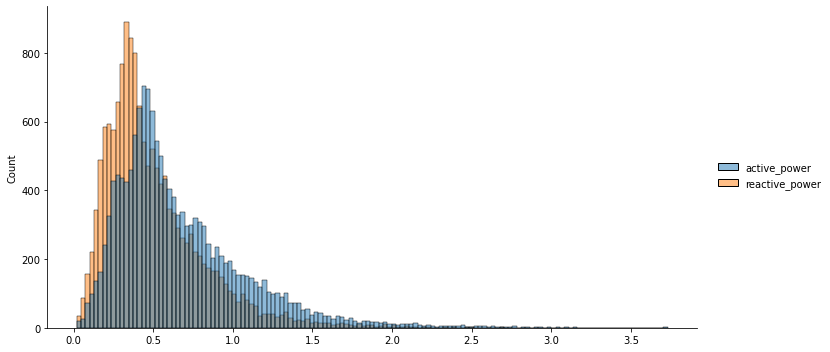

In [10]:
sns.displot(data=data_arc[['active_power', 'reactive_power']], aspect=2)

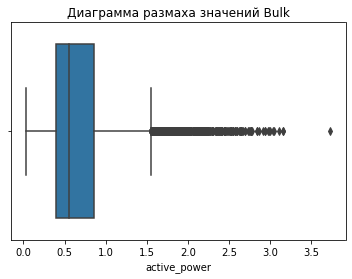

<AxesSubplot:xlabel='reactive_power'>

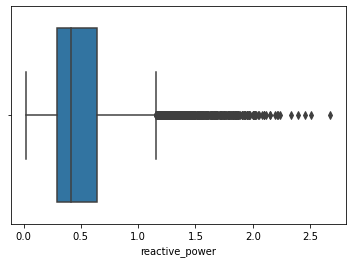

In [11]:
plt.title('Диаграмма размаха значений Bulk')

sns.boxplot(data_arc['active_power'])

plt.show()

sns.boxplot(data_arc['reactive_power'])

In [12]:
display('Данные о подаче сыпучих материалов (объём)', data_bulk)

'Данные о подаче сыпучих материалов (объём)'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [13]:
display('Количество дубликатов "Данные о подаче сыпучих материалов (объём)":', data_bulk.duplicated().sum())
display('Количество пропущенных значений "Данные о подаче сыпучих материалов (объём)":', data_bulk.isna().sum())

'Количество дубликатов "Данные о подаче сыпучих материалов (объём)":'

0

'Количество пропущенных значений "Данные о подаче сыпучих материалов (объём)":'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [14]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<AxesSubplot:>

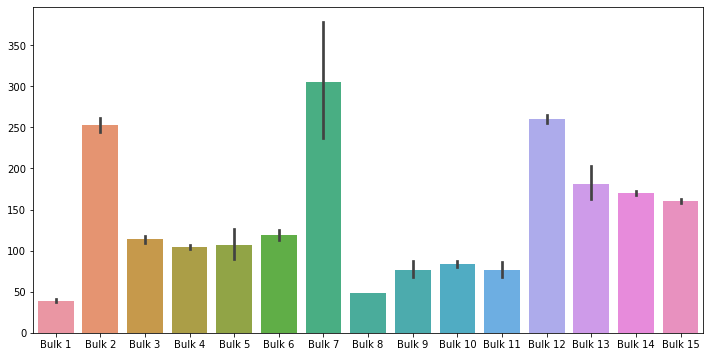

In [15]:
plt.figure(figsize=(12, 6))

sns.barplot(data=data_bulk.drop('key', axis=1))

Text(0.5, 1.0, 'Диаграмма размаха значений Bulk')

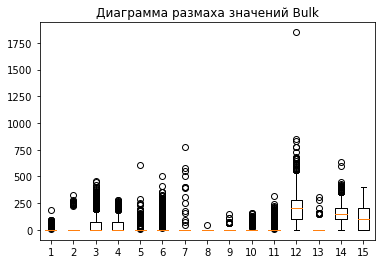

In [94]:
plt.boxplot(data_bulk.drop('key', axis=1))
plt.title('Диаграмма размаха значений Bulk')

Видно много пропущенных значений. Скорее всего это связано с тем, что не все виды сыпучих материалов подаются. Заменю пропущенные значения на 0 как неподанные.

In [17]:
data_bulk[data_bulk.isna()] = 0

#data_bulk

In [18]:
display('Данные о подаче сыпучих материалов (время)', data_bulk_time)

'Данные о подаче сыпучих материалов (время)'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [19]:
display('Количество дубликатов "Данные о подаче сыпучих материалов (время)":', data_bulk_time.duplicated().sum())
display('Количество пропущенных значений "Данные о подаче сыпучих материалов (время)":', data_bulk_time.isna().sum())

'Количество дубликатов "Данные о подаче сыпучих материалов (время)":'

0

'Количество пропущенных значений "Данные о подаче сыпучих материалов (время)":'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Так же видно много пропущенных значений. В этой таблице указано, когда были поданы сыпучие материалы. И, поскольку, не все виды сыпучих материалов подаются, заменю пропущенные значения на 0 как неподанные.

In [20]:
display('Данные о продувке сплава газом', data_gas)

'Данные о продувке сплава газом'

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [21]:
data_gas.rename(columns = {'Газ 1': 'gas_1'},
                inplace = True)

#data_gas

In [22]:
display('Количество дубликатов "Данные о продувке сплава газом":', data_gas.duplicated().sum())
display('Количество пропущенных значений "Данные о продувке сплава газом":', data_gas.isna().sum())

'Количество дубликатов "Данные о продувке сплава газом":'

0

'Количество пропущенных значений "Данные о продувке сплава газом":'

key      0
gas_1    0
dtype: int64

Таблица полностью заполнена.

In [23]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


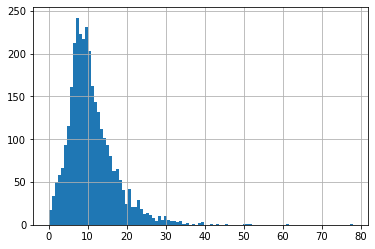

{'whiskers': [<matplotlib.lines.Line2D at 0x138a7ffbb50>,
 'caps': [<matplotlib.lines.Line2D at 0x138a80082b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x138a7ffb8e0>],
 'medians': [<matplotlib.lines.Line2D at 0x138a80089d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x138a8008d60>],
 'means': []}

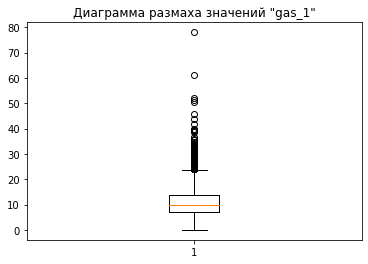

In [24]:
data_gas['gas_1'].hist(bins=100)

plt.show()

plt.title('Диаграмма размаха значений "gas_1"')
plt.boxplot(data_gas['gas_1'])

In [25]:
display('Результаты измерения температуры', data_temp)

'Результаты измерения температуры'

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [26]:
data_temp.rename(columns = {'Время замера': 'meas_time',
                           'Температура': 'temp'
                          },
                inplace = True)

#data_temp

In [27]:
display('Количество дубликатов "Результаты измерения температуры":', data_temp.duplicated().sum())
display('Количество пропущенных значений "Результаты измерения температуры":', data_temp.isna().sum())

'Количество дубликатов "Результаты измерения температуры":'

0

'Количество пропущенных значений "Результаты измерения температуры":'

key             0
meas_time       0
temp         2901
dtype: int64

In [28]:
data_temp['temp'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: temp, dtype: float64

In [29]:
display('Данные о проволочных материалах (объём)', data_wire)

'Данные о проволочных материалах (объём)'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
display('Количество дубликатов "Данные о проволочных материалах (объём)":', data_wire.duplicated().sum())
display('Количество пропущенных значений "Данные о проволочных материалах (объём)":', data_wire.isna().sum())

'Количество дубликатов "Данные о проволочных материалах (объём)":'

0

'Количество пропущенных значений "Данные о проволочных материалах (объём)":'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [31]:
data_wire[data_wire.isna()] = 0

data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Много пропущенных значений. Заполню пропуски значением 0, т.к. если значение не указано, значит материал не подавался.

In [32]:
display('Данные о проволочных материалах (время)', data_wire_time)

'Данные о проволочных материалах (время)'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
display('Количество дубликатов "Данные о проволочных материалах (время)":', data_wire_time.duplicated().sum())
display('Количество пропущенных значений "Данные о проволочных материалах (время)":', data_wire_time.isna().sum())

'Количество дубликатов "Данные о проволочных материалах (время)":'

0

'Количество пропущенных значений "Данные о проволочных материалах (время)":'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Много пропущенных значений - не заполнены те строки, когда матерал не подавался.

Считаю, что время - не информативный признак, т.к. не несет смысловой нагрузки, и таблицы с указанием времени можно не использовать в работе.
<br>Итого для проектирования модели нам нужны таблицы:
<br>data_arc.csv — данные об электродах;
<br>data_bulk.csv — данные о подаче сыпучих материалов (объём);
<br>data_wire.csv — данные о проволочных материалах (объём);
<br>data_gas.csv — данные о продувке сплава газом;
<br>data_temp.csv — результаты измерения температуры.

Удалю номера партий из используемых в анализе таблиц, по которым отсутствует температура в таблице data_temp.

Посмотрим количество замеров температуры по партиям и удалим те, в которых всего 1 замер, т.к. нужно хотя бы два значения: начальное и конечное, из которых для целевого признака нужно последнее значение замера температуры.

In [34]:
vc = pd.DataFrame(data_temp['key'].value_counts().reset_index())

vc = vc.rename(columns = {'key': 'iter_count',
                          'index': 'key'
                         }
              )
vc

,key,iter_count
0,46,16
1,1214,16
2,44,16
3,1513,16
4,2108,15
...,...,...
3211,1160,2
3212,982,2
3213,2456,2
3214,195,1


In [35]:
nan_key.extend( vc[vc['iter_count'] <= 1]['key'] ) 

#nan_key

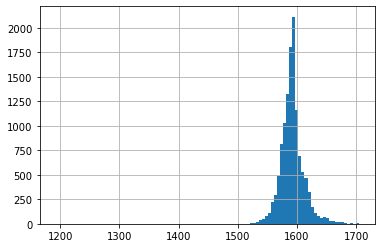

Text(0.5, 1.0, 'Диаграмма размаха значений "temp"')

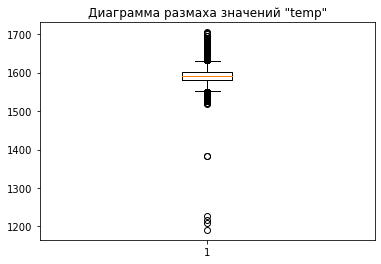

In [95]:
data_temp['temp'].hist(bins=100)

plt.show()

plt.boxplot(data_temp['temp'])
plt.title('Диаграмма размаха значений "temp"')

В некоторых строках пропущена температура. Поскольку это наш целевой признак, считаю разумным удалить строки с пропущенными значения и удалить эти партии из других таблиц.

In [37]:
nan_key.extend( data_temp[data_temp['temp'].isna()]['key'] )

display('Номера партий, которые были исключены:', nan_key)

'Номера партий, которые были исключены:'

[2116,
 195,
 279,
 2500,
 2500,
 2500,
 2501,
 2501,
 2501,
 2501,
 2502,
 2502,
 2502,
 2502,
 2502,
 2502,
 2503,
 2503,
 2503,
 2504,
 2504,
 2505,
 2505,
 2505,
 2505,
 2506,
 2506,
 2506,
 2506,
 2506,
 2506,
 2506,
 2507,
 2507,
 2507,
 2507,
 2507,
 2508,
 2508,
 2508,
 2508,
 2508,
 2508,
 2509,
 2509,
 2509,
 2509,
 2509,
 2510,
 2510,
 2510,
 2510,
 2510,
 2511,
 2511,
 2511,
 2511,
 2511,
 2511,
 2512,
 2512,
 2513,
 2513,
 2513,
 2514,
 2514,
 2514,
 2514,
 2514,
 2515,
 2515,
 2515,
 2515,
 2516,
 2516,
 2516,
 2517,
 2517,
 2517,
 2517,
 2517,
 2517,
 2517,
 2518,
 2518,
 2518,
 2519,
 2519,
 2519,
 2520,
 2520,
 2520,
 2520,
 2521,
 2521,
 2522,
 2522,
 2523,
 2523,
 2523,
 2524,
 2524,
 2524,
 2524,
 2524,
 2525,
 2525,
 2525,
 2525,
 2525,
 2525,
 2525,
 2526,
 2526,
 2526,
 2526,
 2526,
 2526,
 2527,
 2527,
 2528,
 2528,
 2528,
 2528,
 2528,
 2529,
 2529,
 2529,
 2530,
 2530,
 2530,
 2531,
 2531,
 2531,
 2532,
 2532,
 2532,
 2533,
 2533,
 2533,
 2533,
 2533,
 2534,
 

In [38]:
len(nan_key)

2904

In [39]:
data_temp

,key,meas_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [40]:
data_temp = data_temp.drop(data_temp[data_temp['temp'].isna()].index)

In [41]:
data_temp = data_temp.query('key not in @nan_key')

data_temp

,key,meas_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Целевым признаком будет последняя измеренная температура в каждой партии.
Во всех таблицах нужно сгруппировать данные по номеру партии, чтобы получить признаки для обучения моделей.

In [42]:
data_temp['meas_time'] = pd.to_datetime(data_temp['meas_time'])

In [43]:
last_time_temp = pd.to_datetime(data_temp.groupby('key')['meas_time'].max())

#last_time_temp

In [44]:
temp_target = data_temp.merge(last_time_temp, on='meas_time')

temp_target = temp_target.rename(columns={'meas_time': 'last_time',
                                          'temp': 'last_time_temp'
                                         }
                                )

temp_target

,key,last_time,last_time_temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
2469,2495,2019-08-06 00:54:42,1591.0
2470,2496,2019-08-06 01:29:52,1591.0
2471,2497,2019-08-06 01:53:50,1589.0
2472,2498,2019-08-06 02:25:31,1594.0


In [45]:
first_time_temp = pd.to_datetime(data_temp.groupby('key')['meas_time'].min())

#first_time_temp

In [46]:
first_temp = data_temp.merge(first_time_temp, on='meas_time')

first_temp = first_temp.rename(columns={'meas_time': 'first_time',
                                        'temp': 'first_time_temp'
                                        }
                              )

first_temp

,key,first_time,first_time_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
2469,2495,2019-08-06 00:35:45,1570.0
2470,2496,2019-08-06 01:02:54,1554.0
2471,2497,2019-08-06 01:41:53,1571.0
2472,2498,2019-08-06 02:03:49,1591.0


In [47]:
data_arc = data_arc.query('key not in @nan_key')

data_arc

,key,start_time,end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252


In [48]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'], format='%Y-%m-%d')
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'], format='%Y-%m-%d')

In [49]:
#продолжительность нагрева

data_arc['duration'] = (data_arc['end_time'] - data_arc['start_time']) // pd.Timedelta('1s')

data_arc

,key,start_time,end_time,active_power,reactive_power,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295


In [50]:
#суммы мощностей всех циклов в партиях

data_arc_sum = data_arc.groupby('key')['active_power', 'reactive_power'].sum()

data_arc_sum = data_arc_sum.rename(columns={'active_power': 'active_power_sum',
                                             'reactive_power': 'reactive_power_sum'
                                            }
                                    )

data_arc_sum

,active_power_sum,reactive_power_sum
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
2495,3.210690,2.360777
2496,4.203064,2.810185
2497,2.212379,1.851269


In [51]:
#количество циклов в партиях

data_arc_sum['iter_count'] = data_arc['key'].value_counts().sort_index()

data_arc_sum

,active_power_sum,reactive_power_sum,iter_count
key,,,
1,4.878147,3.183241,5
2,3.052598,1.998112,4
3,2.525882,1.599076,5
4,3.209250,2.060298,4
5,3.347173,2.252643,4
...,...,...,...
2495,3.210690,2.360777,4
2496,4.203064,2.810185,6
2497,2.212379,1.851269,3


In [52]:
#суммарная продолжителньость циклов в партиях

data_arc_sum['sum_dur'] = data_arc.groupby('key')['duration'].sum()

data_arc_sum

,active_power_sum,reactive_power_sum,iter_count,sum_dur
key,,,,
1,4.878147,3.183241,5,1098
2,3.052598,1.998112,4,811
3,2.525882,1.599076,5,655
4,3.209250,2.060298,4,741
5,3.347173,2.252643,4,869
...,...,...,...,...
2495,3.210690,2.360777,4,723
2496,4.203064,2.810185,6,940
2497,2.212379,1.851269,3,569


In [53]:
data_wire = data_wire.query('key not in @nan_key')

data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2368,2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2370,2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2371,2498,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
data_bulk = data_bulk.query('key not in @nan_key')

data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2404,2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2405,2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2406,2498,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


In [55]:
data_gas = data_gas.query('key not in @nan_key')

data_gas

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
2495,2498,14.953657
2496,2499,11.336151
2680,2683,0.338997
3197,3200,0.908588


In [56]:
# размеры таблиц

data_arc.shape, data_wire.shape, data_bulk.shape, data_gas.shape, data_temp.shape

((11445, 6), (2371, 10), (2406, 16), (2497, 2), (12261, 3))

In [57]:
data = data_gas.merge(temp_target, on='key')

data

,key,gas_1,last_time,last_time_temp
0,1,29.749986,2019-05-03 11:30:39,1613.0
1,2,12.555561,2019-05-03 11:59:12,1602.0
2,3,28.554793,2019-05-03 12:34:57,1599.0
3,4,18.841219,2019-05-03 12:59:25,1625.0
4,5,5.413692,2019-05-03 13:36:01,1602.0
...,...,...,...,...
2467,2495,7.125735,2019-08-06 00:54:42,1591.0
2468,2496,9.412616,2019-08-06 01:29:52,1591.0
2469,2497,6.271699,2019-08-06 01:53:50,1589.0
2470,2498,14.953657,2019-08-06 02:25:31,1594.0


In [58]:
data = data.merge(first_temp, on='key')

data

,key,gas_1,last_time,last_time_temp,first_time,first_time_temp
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0
...,...,...,...,...,...,...
2467,2495,7.125735,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0
2468,2496,9.412616,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0
2469,2497,6.271699,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0
2470,2498,14.953657,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0


In [59]:
data = data.merge(data_arc_sum, on='key')

data

,key,gas_1,last_time,last_time_temp,first_time,first_time_temp,active_power_sum,reactive_power_sum,iter_count,sum_dur
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,5,1098
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,4,811
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,5,655
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,4,741
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,4,869
...,...,...,...,...,...,...,...,...,...,...
2467,2495,7.125735,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,3.210690,2.360777,4,723
2468,2496,9.412616,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,4.203064,2.810185,6,940
2469,2497,6.271699,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,2.212379,1.851269,3,569
2470,2498,14.953657,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,3.408725,2.355428,5,750


In [60]:
data = data.merge(data_bulk, on='key')

data

,key,gas_1,last_time,last_time_temp,first_time,first_time_temp,active_power_sum,reactive_power_sum,iter_count,sum_dur,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,5,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,4,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,5,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,4,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,4,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399,2495,7.125735,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,3.210690,2.360777,4,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2400,2496,9.412616,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,4.203064,2.810185,6,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2401,2497,6.271699,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,2.212379,1.851269,3,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2402,2498,14.953657,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,3.408725,2.355428,5,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


In [61]:
data = data.merge(data_wire, on='key')

data

,key,gas_1,last_time,last_time_temp,first_time,first_time_temp,active_power_sum,reactive_power_sum,iter_count,sum_dur,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,29.749986,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,5,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,12.555561,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,4,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28.554793,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,5,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,18.841219,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,4,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5.413692,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,4,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,7.125735,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,3.210690,2.360777,4,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,2496,9.412616,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,4.203064,2.810185,6,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2497,6.271699,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,2.212379,1.851269,3,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2498,14.953657,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,3.408725,2.355428,5,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
data = data.drop(['last_time', 'first_time'], axis=1)

In [63]:
display('Сводная таблица', data)

'Сводная таблица'

,key,gas_1,last_time_temp,first_time_temp,active_power_sum,reactive_power_sum,iter_count,sum_dur,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,29.749986,1613.0,1571.0,4.878147,3.183241,5,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,12.555561,1602.0,1581.0,3.052598,1.998112,4,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28.554793,1599.0,1596.0,2.525882,1.599076,5,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,18.841219,1625.0,1601.0,3.209250,2.060298,4,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5.413692,1602.0,1576.0,3.347173,2.252643,4,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,7.125735,1591.0,1570.0,3.210690,2.360777,4,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,2496,9.412616,1591.0,1554.0,4.203064,2.810185,6,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2497,6.271699,1589.0,1571.0,2.212379,1.851269,3,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2498,14.953657,1594.0,1591.0,3.408725,2.355428,5,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
display('Матрица корреляции', data.corr())

'Матрица корреляции'

,key,gas_1,last_time_temp,first_time_temp,active_power_sum,reactive_power_sum,iter_count,sum_dur,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.043516,-0.096599,-0.019051,-0.028770,0.007651,-0.033055,-0.028804,-0.078118,-0.006165,-0.006947,-0.025827,0.035284,0.005180,0.052393,0.015508,-0.039692,0.063021,0.035033,0.026666,-0.015763,-0.110598,-0.044828,-0.013244,0.043437,-0.027219,0.049297,NaN,-0.008180,0.037029,-0.035970,0.021366
gas_1,-0.043516,1.000000,0.059203,0.037345,0.373912,0.356979,0.404058,0.396497,0.234148,0.217417,0.059641,0.017589,0.086904,0.139723,0.198312,0.004128,0.116578,-0.008504,0.042030,0.217433,0.049057,0.268898,0.043662,0.117331,0.104261,0.103384,0.145414,NaN,0.108091,0.078953,0.118069,0.014071
last_time_temp,-0.096599,0.059203,1.000000,0.252389,0.289907,0.240385,0.180640,0.278112,-0.075401,-0.082532,-0.036365,0.187687,-0.028436,-0.180843,-0.107357,-0.026610,-0.016124,0.061233,-0.114912,0.266851,-0.010969,0.114991,0.265801,0.317362,-0.207076,-0.047624,-0.159821,NaN,-0.084135,-0.137336,-0.010813,-0.027553
first_time_temp,-0.019051,0.037345,0.252389,1.000000,-0.347893,-0.325945,-0.141537,-0.305299,0.072301,0.119795,-0.104478,0.144715,0.068377,-0.096800,0.074723,-0.009322,-0.026225,0.035381,-0.087815,-0.058673,0.018598,-0.130971,-0.040533,0.209392,-0.086157,-0.000192,0.064984,NaN,0.019872,0.044768,-0.023270,0.004300
active_power_sum,-0.028770,0.373912,0.289907,-0.347893,1.000000,0.958457,0.760483,0.978101,0.084475,0.031060,0.112458,-0.031406,0.006455,0.154457,0.074415,-0.011416,0.023705,0.004654,0.071109,0.477708,0.122454,0.465688,0.333861,0.050699,0.054402,0.035587,0.047620,NaN,0.053299,0.019638,0.029465,-0.016214
reactive_power_sum,0.007651,0.356979,0.240385,-0.325945,0.958457,1.000000,0.754872,0.965448,0.108834,0.051988,0.068993,-0.032748,0.018919,0.145344,0.100976,-0.008365,0.011076,-0.002635,0.075908,0.456854,0.116740,0.430503,0.296677,0.016581,0.052033,0.030697,0.075679,NaN,0.055178,0.036897,0.016561,-0.012182
iter_count,-0.033055,0.404058,0.180640,-0.141537,0.760483,0.754872,1.000000,0.798932,0.097688,0.093060,0.108989,-0.004527,0.074989,0.153141,0.152486,-0.008979,0.038214,0.012615,0.062533,0.306818,0.117713,0.334253,0.174521,0.138041,0.078023,0.055238,0.113646,NaN,0.053364,0.073666,0.043887,-0.024596
sum_dur,-0.028804,0.396497,0.278112,-0.305299,0.978101,0.965448,0.798932,1.000000,0.102925,0.038188,0.092347,-0.028640,0.013467,0.163067,0.084611,-0.011304,0.012917,-0.005147,0.078103,0.466359,0.129273,0.461740,0.295245,0.055142,0.054251,0.033353,0.054787,NaN,0.042246,0.027613,0.017846,-0.011631
Bulk 1,-0.078118,0.234148,-0.075401,0.072301,0.084475,0.108834,0.097688,0.102925,1.000000,0.224696,-0.011704,0.041775,0.060417,-0.003389,0.237209,-0.005727,-0.019765,-0.023216,-0.037915,0.325742,-0.010288,0.207799,-0.000968,0.013609,-0.009292,0.020258,0.146296,NaN,0.148551,0.083441,-0.019544,0.011056
Bulk 2,-0.006165,0.217417,-0.082532,0.119795,0.031060,0.051988,0.093060,0.038188,0.224696,1.000000,-0.046912,0.040775,0.360300,-0.029945,0.679355,-0.001546,-0.005335,-0.018023,0.001473,-0.099043,-0.005595,-0.140944,-0.105784,-0.169512,-0.039077,0.223199,0.699342,NaN,0.558888,0.431737,-0.005276,-0.006845


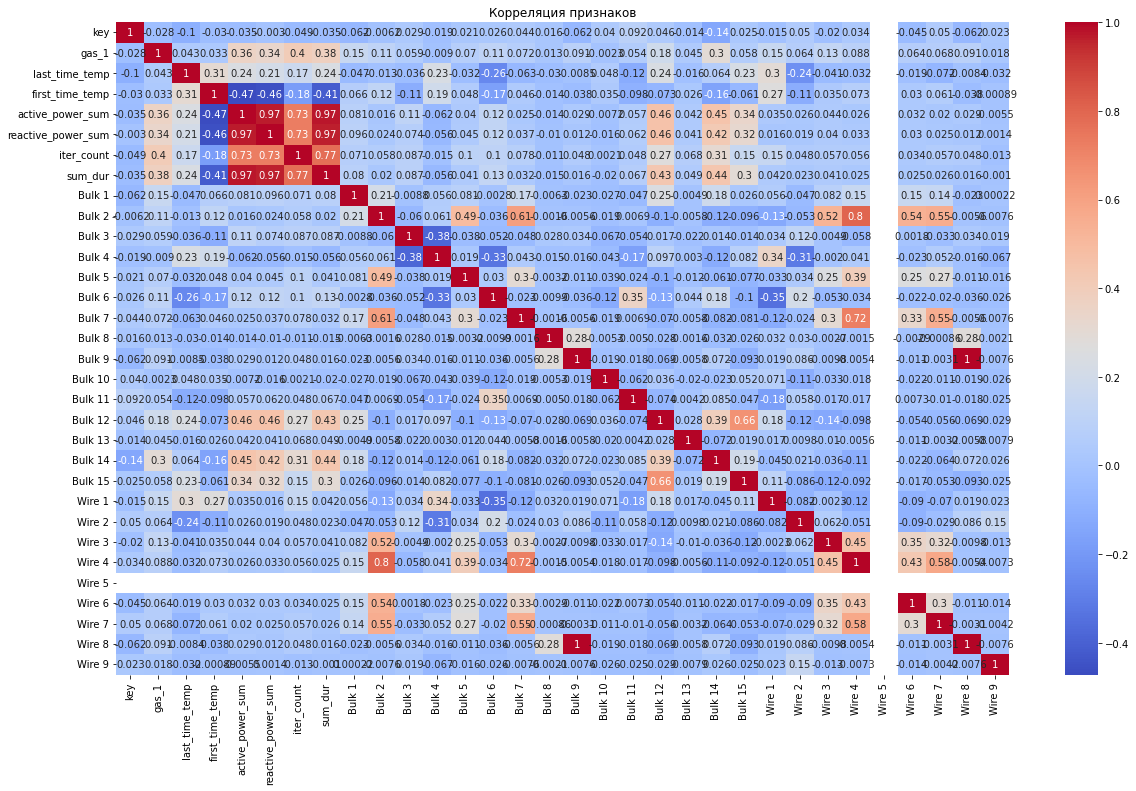

In [65]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

Из heatmap видно, что есть сильные зависимости между (больше 0,9) active_power_sum и reactive_power_sum, active_power_sum, active_power_sum и sum_dur, а также Bulk 9 и Wire 8.
<br>Гугл подсказал, что "Фактически, активная мощность определяет скорость полезного потребления энергии. Реактивная мощность — мощность определяемая электромагнитными полями, образующимися в процессе работы приборов.". Поскольку нам нужно экономить электричество, active_power_sum важнее и нужнее для анализа, оставляю этот признак.
<br>Признак sum_dur - продолжительность циклов в партиях не нужен в виду того, что суммарная потребленная энергия в партиях отражена в active_power_sum.
<br>Из Bulk 9 и Wire 8 оставляю Bulk 9. Тут просто выбрала одно из двух.
<br>Из этих соображений удалю признаки reactive_power_sum, sum_dur и Wire 8, еще нужно удалить признак Wire 5, т.к. в нем нет информации.

In [66]:
data = data.drop(['reactive_power_sum', 'sum_dur', 'Wire 8', 'Wire 5', 'key'], axis=1)

Повторю вывод heatmap после удаления признаков.

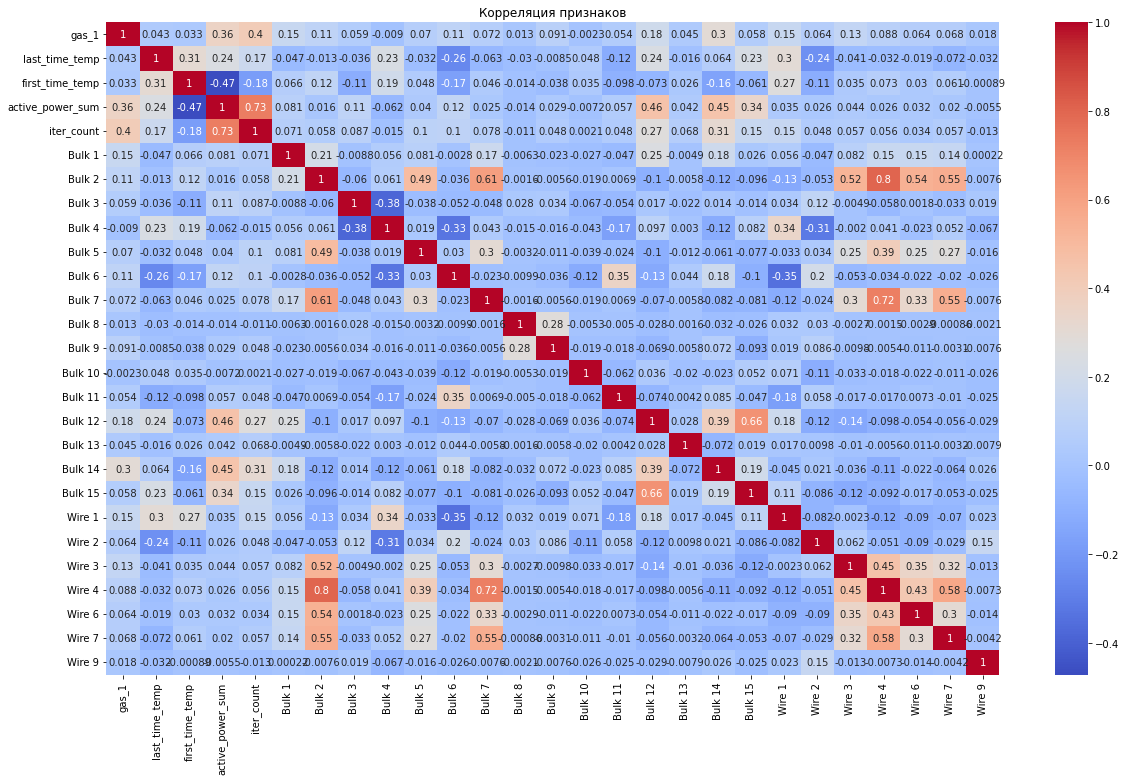

In [67]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

## Разбивка данных

Разделим данные на тренировочную и тестовые выборки.

In [68]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=3102022)

print('Размеры таблиц:',
      '\ntrain_data =', train_data.shape,
#       '\nsplit_data =', split_data.shape
      '\ntest_data =', test_data.shape
     )

Размеры таблиц: 
train_data = (1746, 27) 
test_data = (582, 27)


In [69]:
1746+582

2328

In [70]:
features_train = train_data.drop('last_time_temp', axis=1)
target_train = train_data['last_time_temp']

features_train.shape, target_train.shape

((1746, 26), (1746,))

In [71]:
features_train.columns

Index(['gas_1', 'first_time_temp', 'active_power_sum', 'iter_count', 'Bulk 1',
       'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8',
       'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
       'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7',
       'Wire 9'],
      dtype='object')

In [72]:
features_test = test_data.drop('last_time_temp', axis=1)
target_test = test_data['last_time_temp']

features_test.shape, target_test.shape

((582, 26), (582,))

## Обучение моделей

Модель 1 LinearRegression.

In [73]:
model1 = LinearRegression()

In [74]:
scaler = StandardScaler()

scaler.fit(features_train)

features_train_s = scaler.transform(features_train)

In [75]:
%%time

MAE1 = abs(cross_val_score(model1, 
                           features_train_s, 
                           target_train, 
                           cv=5, 
                           scoring='neg_mean_absolute_error').mean()
           )

print('MAE модели 1 =', MAE1)

MAE модели 1 = 6.392453045621269
Wall time: 172 ms


In [76]:
num = [int(x) for x in np.linspace(start=100, stop=1000, num=100)]
depth = [int(x) for x in np.linspace(start=10, stop=50, num=5)]
mins = [int(x) for x in np.linspace(start=5, stop=50, num=5)]
minl = [int(x) for x in np.linspace(start=10, stop=50, num=5)]

dt_grid = {'max_depth': depth, 
           'min_samples_split': mins, 
           'min_samples_leaf': minl
          }

rf_grid = {'n_estimators': num,
           'max_depth': depth,
           #'min_samples_split': mins,
           'min_samples_leaf': minl
          }

Модель 2 DecisionTreeRegressor.

In [77]:
model2 = GridSearchCV(DecisionTreeRegressor(random_state=3102022),
                      dt_grid,
                      scoring='neg_mean_absolute_error',
                      cv=5
                     )

In [78]:
%%time

model2.fit(features_train, target_train)

Wall time: 20.1 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=3102022),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'min_samples_split': [5, 16, 27, 38, 50]},
             scoring='neg_mean_absolute_error')

In [79]:
model2_best_params = model2.best_params_

display('Наилучшие гиперпараметры модели 2:', model2_best_params)

'Наилучшие гиперпараметры модели 2:'

{'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 5}

In [80]:
MAE2 = abs(model2.best_score_)

print('MAE модели 2 =', MAE2)

MAE модели 2 = 6.79230523629902


Модель 3 RandomForestRegressor.

In [81]:
model3 = RandomizedSearchCV(RandomForestRegressor(random_state=3102022),
                            rf_grid,
                            scoring='neg_mean_absolute_error',
                            cv=5
                            )

In [82]:
%%time

model3.fit(features_train, target_train)

Wall time: 5min 49s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=3102022),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             50],
                                        'n_estimators': [100, 109, 118, 127,
                                                         136, 145, 154, 163,
                                                         172, 181, 190, 200,
                                                         209, 218, 227, 236,
                                                         245, 254, 263, 272,
                                                         281, 290, 300, 309,
                                                         318, 327, 336, 345,
                                                         354, 363, ...]},
                   scoring='neg_mean_absolute_error')

In [83]:
model3_best_params = model3.best_params_

display('Наилучшие гиперпараметры модели 3:', model3_best_params)

'Наилучшие гиперпараметры модели 3:'

{'n_estimators': 536, 'min_samples_leaf': 10, 'max_depth': 20}

In [84]:
MAE3 = abs(model3.best_score_)

print('MAE модели 3 =', MAE3)

MAE модели 3 = 6.1605229250724225


Выведу таблицу с результатами исследования.

In [85]:
pd.set_option('max_colwidth', 500)

In [86]:
m = ['LinearRegression', 'DecisionTreeClassifier', 'RandomForestRegressor']

mae = [MAE1, MAE2, MAE3]

# h = ['', model2.best_params_, model3.best_params_]

In [87]:
models = pd.DataFrame(
                      {'MAE': mae,
#                        'Наилучшие гиперпараметры': h,
                      },
                      index=m
                     )

display('Таблица значений рассмотренных моделей:', models)

'Таблица значений рассмотренных моделей:'

,MAE
LinearRegression,6.392453
DecisionTreeClassifier,6.792305
RandomForestRegressor,6.160523


In [88]:
display('Наилучшая модель:',
         models[models['MAE'] == models['MAE'].min()]
       )

'Наилучшая модель:'

,MAE
RandomForestRegressor,6.160523


## Тестирование модели

In [89]:
predict = model3.predict(features_test)

In [90]:
print('MAE наилучшей модели =', mean_absolute_error(target_test, predict))

MAE наилучшей модели = 5.825918974183572


In [96]:
# plt.figure(figsize=(15, 7))
# plt.plot(predict, 'r', label='Предсказанная температура стали на выходе')
# plt.plot(target_test.values, label='Фактическая температура стали на выходе')
# plt.legend(loc='best')
# plt.title("MAE на тестовой выборке {}".format(round(mean_absolute_error(predict, target_test), 1)))
# plt.grid(True)

In [92]:
features_imp = pd.Series(model3.best_estimator_.feature_importances_ ,index=features_train.columns).sort_values(ascending=False)

# features_imp

Text(0, 0.5, 'Признаки')

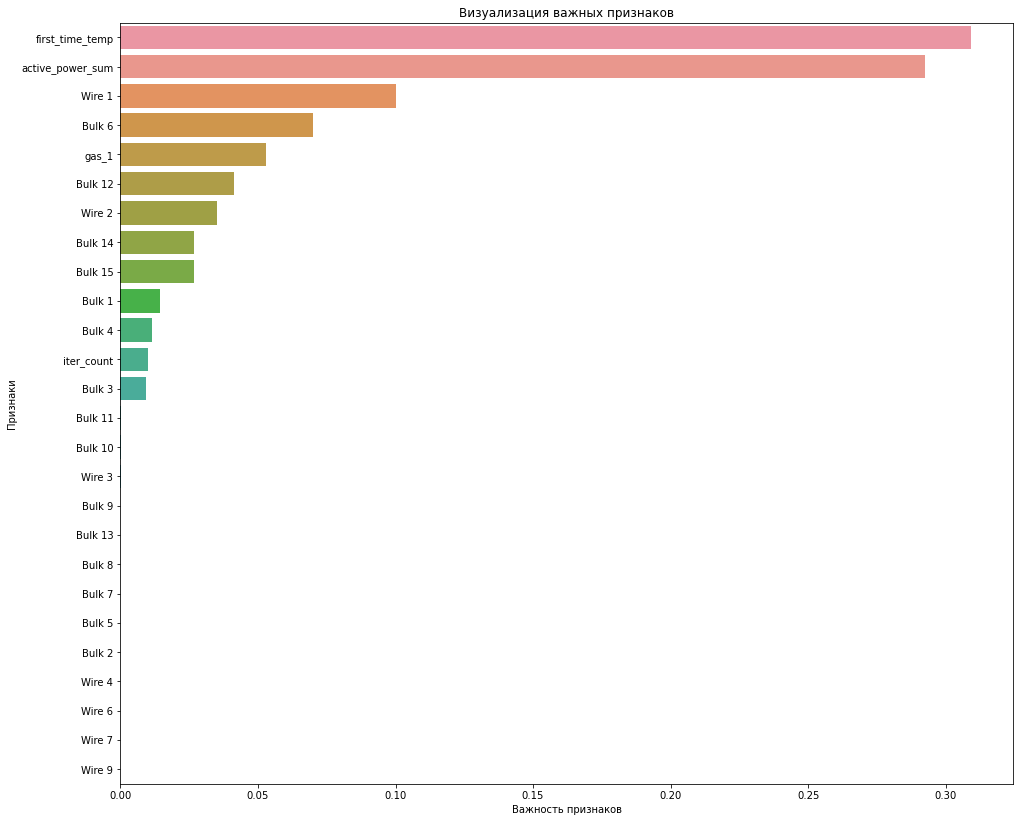

In [93]:
plt.subplots(figsize=(16,14))

sns.barplot(x=features_imp, y=features_imp.index)

plt.title('Визуализация важных признаков')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')

<a id='section1'></a>
## Отчет по решению

<br>Для проектирования модели были использованы таблицы:
<br>data_arc.csv — данные об электродах;
<br>data_bulk.csv — данные о подаче сыпучих материалов (объём);
<br>data_wire.csv — данные о проволочных материалах (объём);
<br>data_gas.csv — данные о продувке сплава газом;
<br>data_temp.csv — результаты измерения температуры.
<br>Таблицы с указанием времени подачи материалов data_bulk_time.csv и data_wire_time.csv не были использованы как не несущие смысловой нагрузки.

<br>При подготовке признаков для моделирования было выполнено следующее:
<br>Пропущенные значения замера темепературы в таблице data_temp.csv были удалены, т.к. это целевой признак и он не может быть пустым.
<br>Пропущенные значения в таблицах data_bulk.csv и data_wire.csv были заменены на 0 как неподанные, т.к. подаются не все легирующие добавки.
<br>Вычислено количество замеров температуры по партиям в таблице data_arc.csv и удалены те, в которых всего 1 замер, т.к. нужно хотя бы два значения: начальное и конечное, из которых для целевого признака нужно последнее значение замера температуры. Также из таблицы data_arc.csv были удалены партии с отрицательными значениями реактивной мощности. 
<br>Из всех используемых в анализе таблиц были удалены партии, в которых недостаточно данных для анализа и которые не могут быть переданы модели, т.к. объектом моделировани является отдельная партия и для того, чтобы спрогнозировать выходную температуру стали, требуются полные данные всей партии.
<br>Во всех партиях вычислены:
<br>- количество циклов;
<br>- суммы мощностей всех циклов;
<br>- суммарная продолжителньость циклов;
<br>С вышеперечиленными данными все таблицы были объединены по номеру партии в одну сводную таблицу признаков.

<br>Построена тепловая карта для наглядного просмотра мультиколлениарности признаков. Из тепловой карты определено, что есть сильные зависимости (более 0,9) между суммарными активными и реактивными мощностями, суммарными активными и реактивными мощностями и продолжнительностью циклов в партиях, а также между материалами Bulk 9 и Wire 8. Возникла необходимость в удалении коррелирующих факторов.
<br>Поскольку цель заказчика - экономия энергоресурсов, было решено оставить суммарную активную мощность; продолжительность циклов в партиях оказалась не нужна в виду того, что суммарная потребленная энергия в партиях отражена в суммарной активной мощности; также в признаках оставлен один из материалов Bulk 9.
<br>Итого были удалены следующие признаки: суммарная реактивная мощность, суммарная потребленная энергия в партиях, материал Wire 8, материал Wire 5 как не содержащий информации во всех записях и номер партии key как не содержащий информации для целевого признака.

<br>После подготовки сводной таблицы признаков данные были разделены на тренировочную и тестовые выборки в соотношении 0.25.

<br>Т.к. целевой признак - температура стали - количественный, в проекте нужно решить задачу регрессии, поэтому были использованы модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor.
<br>Для модели LinearRegression было выполнено масштабирование признаков, т.к. сильно различался разброс по факторам, и использована кросс-валидация для оценки метрики качества. На тренироввочных данных получено значение MAE модели 1 = 6.392453045621267.
<br>Для модели DecisionTreeRegressor использован подбор гиперпараметров с помощью GridSearchCV, для RandomForestRegressor - RandomizedSearchCV.
<br>На модели DecisionTreeRegressor получено значение метрики качества MAE модели 2 = 6.79230523629902, на RandomForestRegressor - MAE модели 3 = 6.15461549787331.
<br>Наименьшее значение MAE = 6.15461549787331 на тренировочных данных принадлежит модели RandomForestRegressor, таким образом модель RandomForestRegressor является наилучшей для задачи проекта.

<br>На тестовых данных наилучшая модель RandomForestRegressor показала значение метрики качества MAE наилучшей модели = 5.824352384050827. Этот результат означает, что модель может ошибиться примерно на 6 градусов при прогнозировании выходной температуры стали.
    
<br>График важности факторов показал, что самое сильное влияние на целевой признак в порядке убывания значимости имеют признаки:
<br>first_time_temp     0.310305
<br>active_power_sum    0.293510
<br>Wire 1              0.098786
<br>Bulk 6              0.070019
<br>gas_1               0.053077
<br>Bulk 12             0.041290
<br>Wire 2              0.034779
<br>Bulk 14             0.027231
<br>Bulk 15             0.025888
<br>Bulk 1              0.013796
<br>Bulk 4              0.011435
<br>iter_count          0.009740
<br>Bulk 3              0.009544
<br>Bulk 10             0.000284
<br>Признаки Bulk 11, Wire 6, Wire 3, Bulk 9, Bulk 13, Bulk 8, Bulk 7, Bulk 5, Bulk 2, Wire 4, Wire 7, Wire 9 оказались слабозначимыми для модели, т.е. незначительно влияют на целевую переменную.